# Projecte Kaggle: Classificació Automàtica de Gèneres Musicals

**Autors:** Chengjie Peng Lin 1672765 \
**Assignatura:** Aprenentatge Computacional  
**Dataset Kaggle:** [Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data)  

---

## Introducció i Objectius

L'objectiu d'aquest projecte és desenvolupar un model de **Machine Learning supervisat** capaç de classificar automàticament el gènere musical d'una cançó basant-se exclusivament en les seves característiques físiques d'àudio (com ara l'energia, el tempo, la ballabilitat o l'acusticitat), sense utilitzar metadades com el nom de l'artista.

Per a aquest estudi, hem utilitzat el **Spotify Tracks Dataset** extret de Kaggle. Tot i que el dataset original conté més de 114.000 cançons i 114 gèneres, hem realitzat un filtratge estratègic per centrar l'anàlisi en **4 gèneres distintius** (*Classical, Hard-Rock, Acoustic, Dance*) amb un conjunt de dades perfectament equilibrat (**4.000 mostres**).

### Estructura del Projecte
1.  **Exploratory Data Analysis (EDA):** Estudi de correlacions i distribucions per entendre la física del so.
2.  **Preprocessament i Feature Engineering:** Neteja, escalat i creació de noves variables (*Intensity, Chill_Factor*) per millorar la predictibilitat.
3.  **Modelatge:** Avaluació de diversos algorismes (KNN, SVM, Regressió Logística) i implementació d'un model base (**Random Forest**).
4.  **Optimització:** Implementació i afinament d'hiperparàmetres d'un model avançat (**XGBoost**) mitjançant `GridSearchCV`.
5.  **Avaluació Rigorosa:** Validació creuada (K-Fold), anàlisi d'errors, corbes ROC i estudi de sensibilitat del split.

---

### Càrrega de Dades

In [46]:
# ==========================================
# CARGAR LIBRERÍAS Y DATOS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./dataset/dataset.csv')

print(f"El dataset completo tiene {df.shape[0]} canciones y {df.shape[1]} columnas.")

El dataset completo tiene 114000 canciones y 21 columnas.


In [47]:
# ==========================================
# Generes a escollir
# ==========================================

generos_a_elegir = ['acoustic', 'hard-rock', 'dance', 'classical']


datos = df[df['track_genre'].isin(generos_a_elegir)].copy()

print(f"\nNos hemos quedado con {len(datos)} canciones de los géneros: {generos_a_elegir}")
print(datos['track_genre'].value_counts())


Nos hemos quedado con 4000 canciones de los géneros: ['acoustic', 'hard-rock', 'dance', 'classical']
track_genre
acoustic     1000
classical    1000
dance        1000
hard-rock    1000
Name: count, dtype: int64


# Exploratory Data Analysis (EDA) – Anàlisi de Correlacions

Per preparar el nostre model de classificació de gèneres musicals, vam realitzar un **anàlisi de correlacions** entre les característiques físiques de l’àudio (`danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`).

L’objectiu d’aquest pas va ser **identificar quines features aporten informació rellevant i evitar redundàncies**, assegurant que el model aprengui de variables significatives i distintes entre si.

**Key Findings:**

Després d’analitzar la matriu de correlacions, vam seleccionar les features que considerem més rellevants per al nostre model:

* **`energy` i `loudness`**: Tot i que presenten una alta correlació entre si (0,82), reflecteixen la intensitat de la cançó i són clau per diferenciar gèneres enèrgics (*Dance*, *Hard-Rock*) de gèneres suaus (*Classical*, *Acoustic*).

* **`acousticness`**: Molt correlacionada negativament amb `energy` i `loudness` (-0,87 i -0,73). És crucial per identificar gèneres acústics i clàssics enfront de gèneres moderns i electrònics.

* **`danceability`**: Permet diferenciar gèneres més ballables (*Dance*) d’altres menys rítmics (*Classical*, *Hard-Rock*).

* **`valence`**: Tot i que la seva correlació amb altres features és moderada, aporta informació sobre la positivitat de la cançó, útil per distingir gèneres alegres de més melòdics o seriosos.

* **`instrumentalness`**: Útil per separar gèneres instrumentals o acústics de gèneres electrònics i ballables, complementant la informació de `acousticness` i `energy`.

> **Resum:** La selecció d’aquestes features garanteix que el model aprengui de variables amb alta capacitat discriminativa entre gèneres, evitant redundàncies i maximitzant l’eficiència de l’aprenentatge.


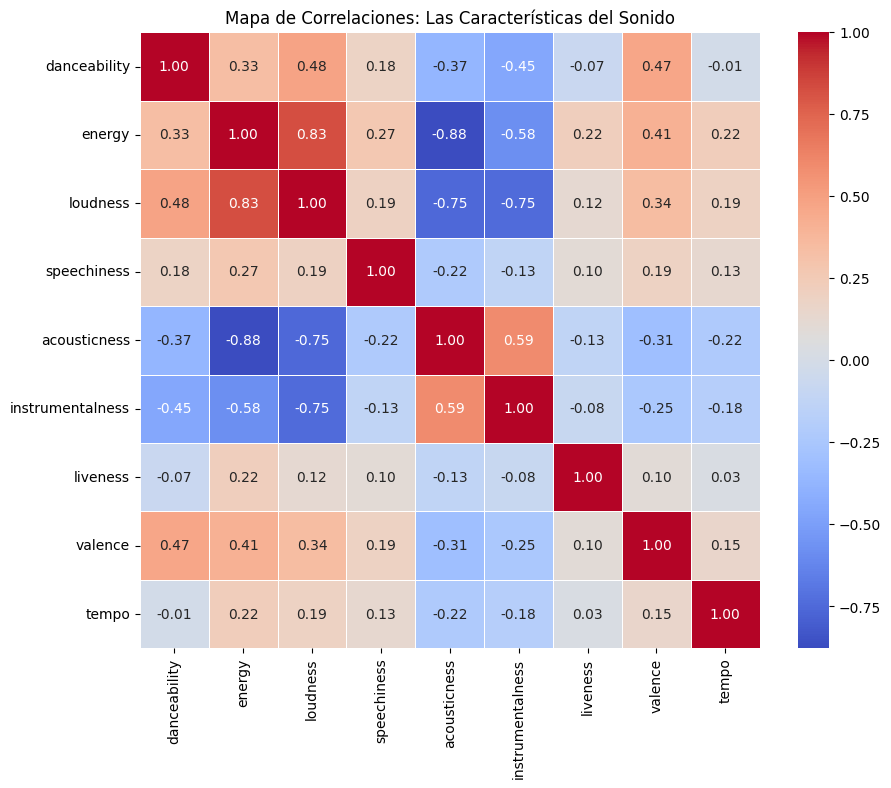

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# EDA PARTE 1: MAPA DE CALOR (CORRELACIONES)
# ==========================================
plt.figure(figsize=(10, 8))

cols_audio = [
    'danceability', 'energy', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

matriz_corr = datos[cols_audio].corr()

sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Correlaciones: Las Características del Sonido')
plt.show()


### Radiografia dels Gèneres (Interpretació de Boxplots)

Aquests gràfics proporcionen una representació visual de com el model percep cada gènere musical a partir de les seves característiques físiques:

1. **Energy (Energia):**

   * **Acoustic:** Energia baixa-mitjana.
   * **Classical:** Energia gairebé nul·la.
   * **Dance:** Energia alta.
   * **Hard-Rock:** Energia molt elevada, propera a 1,0.
   * *Conclusió:* Aquesta variable constitueix un indicador clar per diferenciar gèneres energètics (dance, hard-rock) de gèneres més suaus (acoustic, classical).

2. **Danceability (Ballabilitat):**

   * El gènere **Dance** presenta la mediana més alta, indicant un caràcter marcadament ballable.
   * El **Hard-Rock** mostra valors baixos de ballabilitat, situant-se proper a la música **Classical**.

3. **Acousticness (Acusticitat):**

   * El gènere **Classical** presenta valors elevats d’acusticitat.
   * Els gèneres moderns, com **Dance** i **Hard-Rock**, tenen valors baixos, facilitant la distinció entre estils acústics i electrònics.

**Resum:** Cada gènere exhibeix un patró distintiu de valors que permet al model de Machine Learning establir límits clars entre classes, millorant la precisió de la classificació.


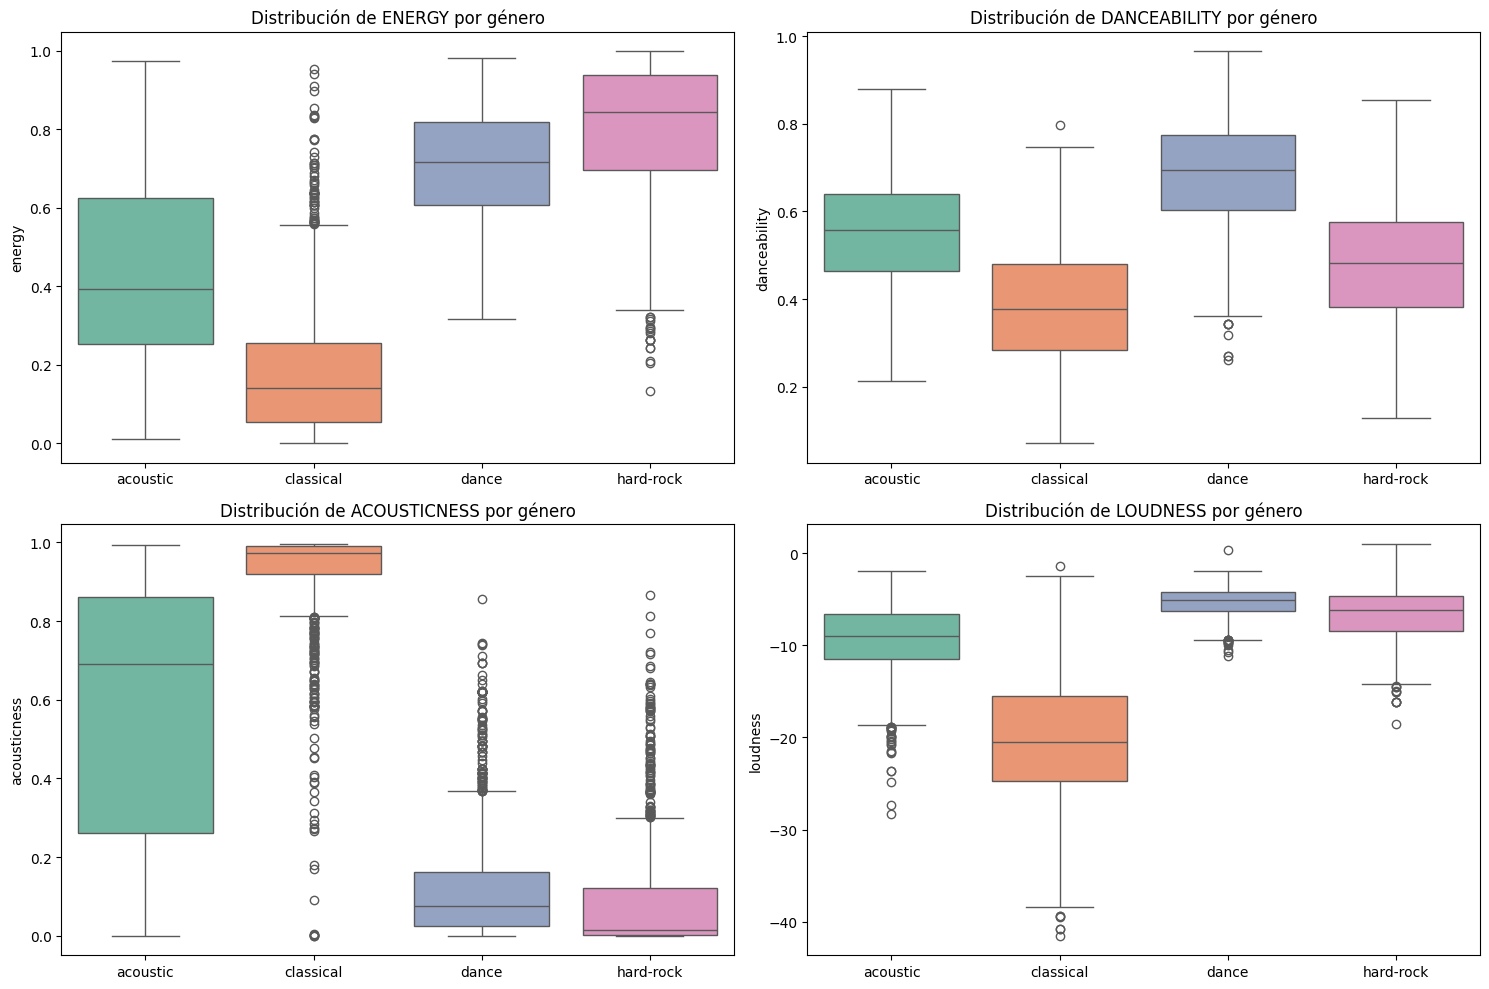

In [49]:
# ==========================================
# EDA PARTE 2: RADIOGRAFÍA DE LOS GÉNEROS
# ==========================================
features_clave = ['energy', 'danceability', 'acousticness', 'loudness']

plt.figure(figsize=(15, 10))

for i, col in enumerate(features_clave):
    plt.subplot(2, 2, i+1)
    
    sns.boxplot(
        x='track_genre', 
        y=col, 
        data=datos, 
        hue='track_genre',
        palette='Set2', 
        legend=False
    )
    
    plt.title(f'Distribución de {col.upper()} por género')
    plt.xlabel('')

plt.tight_layout()
plt.show()

# Preprocessament

### Preparació de Dades i Feature Engineering

En aquesta fase, transformem les dades crues en un format òptim per a l’entrenament del model. Es duen a terme diverses operacions clau: detecció de duplicats, neteja de variables, creació de noves features i divisió del conjunt de dades.

### Detecció i eliminació de duplicats

Abans de qualsevol processament, es comproven i eliminen duplicats per garantir que cada cançó sigui única:

* **Duplicats per `track_id`:** S’eliminen files amb el mateix identificador únic de cançó.
* **Duplicats per combinació `track_name + artists`:** Captura possibles repeticions amb diferents IDs però mateix nom i artista.

Aquesta etapa evita sobreajustos i garanteix que el model aprengui dels patrons musicals reals, no de repeticions de la mateixa cançó.

### Neteja i selecció de variables

Es descarten columnes de metadades que no aporten informació útil al model, com ara:
`track_id`, `artists`, `album_name`, `track_name`, `explicit` i `Unnamed: 0`.

* **Motiu:** L’objectiu és que el model aprengui a distingir gèneres pel **so de les cançons** (freqüències, ritme, energia), i no per noms d’artistes o àlbums.

### Creació de features determinístiques (Feature Engineering)

S’han generat variables sintètiques per captar patrons més complexos:

* **Intensity (Energia × Loudness):** Combina la potència de l’àudio amb el volum per separar cançons molt intenses de les més suaus.
* **Dance_Tempo (Ballabilitat / Tempo):** Ajusta la ballabilitat segons la velocitat de la cançó.
* **Chill_Factor (València − Energia):** Mesura el grau de “tranquil·litat” d’una cançó; valors alts de valència amb baixa energia indiquen estils acústics o clàssics.
* **Electric_Ratio (Energia / Acousticness):** Permet diferenciar cançons més elèctriques de les acústiques.

> **Note:** \
> Les features es calculen **després de separar train i test**, per evitar **data leakage**.

### Divisió del conjunt de dades i codificació de la variable objectiu

*   **Train/Test Split (70/30 estratificat):** Hem optat per reservar un **30%** de les dades per a test i un **70%** per a entrenament.
    > *Nota: Aquesta decisió no és arbitrària. Més endavant, a la secció "Anàlisi de Sensibilitat del Split", demostrarem experimentalment per què aquest repartiment específic (30%) maximitza el rendiment del model en comparació amb l'estàndard 80/20.*

*   **Estratificació (`stratify=y`):** Es manté estrictament la proporció original de gèneres en ambdós conjunts per evitar biaixos de classe i assegurar una avaluació justa.

*   **Label Encoding:** Els gèneres musicals es transformen en valors numèrics. És fonamental destacar que el `fit` de l'encoder es realitza **exclusivament sobre el conjunt de train**, aplicant després la transformació al test. Això prevé qualsevol tipus de *data leakage* (filtració d'informació futura).

In [50]:
# Revisar duplicados por track_id
duplicados_id = datos[datos.duplicated(subset='track_id')]
print(f"Filas duplicadas según track_id: {len(duplicados_id)}")

# Revisar duplicados por track_name + artista
duplicados_name_artist = datos[datos.duplicated(subset=['track_name', 'artists'])]
print(f"Filas duplicadas según track_name + artists: {len(duplicados_name_artist)}")

datos = datos.drop_duplicates(subset='track_id')

datos = datos.drop_duplicates(subset=['track_name', 'artists'])



Filas duplicadas según track_id: 104
Filas duplicadas según track_name + artists: 896


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

datos = datos.drop_duplicates()

columnas_sobrantes = ['track_id', 'artists', 'album_name', 'track_name', 'explicit', 'Unnamed: 0']
df_model = datos.drop(columns=columnas_sobrantes, errors='ignore')
y = df_model['track_genre']
X = df_model.drop(columns=['track_genre'])

def add_features(df_):
    df = df_.copy()
    df['intensity']      = df['energy'] * df['loudness']
    df['dance_tempo']    = df['danceability'] / (df['tempo'] + 1)
    df['chill_factor']   = df['valence'] - df['energy']
    df['electric_ratio'] = df['energy'] / (df['acousticness'] + 0.01)
    return df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_train = add_features(X_train)
X_test  = add_features(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


### Visualització de l'Espai de Característiques (PCA)

Abans d'entrenar cap model, volem entendre la geometria del problema. Projectem les dades en un espai reduït utilitzant **PCA (Principal Component Analysis)** per veure si les classes són fàcilment separables.

**Metodologia Rigorosa (Evitant *Data Leakage*):**
És fonamental destacar que tant l'estandardització (`StandardScaler`) com l'ajust del PCA s'han realitzat **exclusivament sobre el conjunt d'entrenament (Train)**. Posteriorment, hem projectat les dades de test en aquest espai ja definit. Això simula un escenari real i evita que la transformació "vegi" dades futures.

**Anàlisi de la Variança:**
Els resultats mostren que la dimensionalitat del problema és complexa:
- **PC1 (27,52%):** Captura la variació principal, probablement lligada a la potència acústica (*energy, loudness*) vs. acústica.
- **PC2 (13,18%):** Afegeix informació sobre el ritme o la positivitat (*valence, tempo*).
- **Acumulat (3 components):** Amb 3 dimensions només expliquem el **48,96%** de la informació. Això indica que les nostres variables no són redundants i aporten matisos únics.

**Interpretació i Expectatives per al Modelatge:**
El *scatter plot* 2D ens permet anticipar el comportament dels models:
1.  **Fàcil de Classificar:** La classe **Classical** forma un clúster molt compacte i separat. Esperem que qualsevol model obtingui resultats excel·lents aquí.
2.  **Repte per als Models Lineals:** Existeix una zona de frontera difusa i **solapament** entre *hard-rock*, *dance* i *acoustic*. Aquesta barreja visual suggereix que un model lineal simple podria tenir dificultats.

##### **Conclusió**
Com que les classes no són linealment separables en 2D i la variança està molt repartida, **necessitarem models no lineals potents** (com Random Forest o XGBoost) capaços de trobar fronteres de decisió complexes en alta dimensionalitat per distingir correctament els gèneres solapats.

/home/chengjie/apc/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


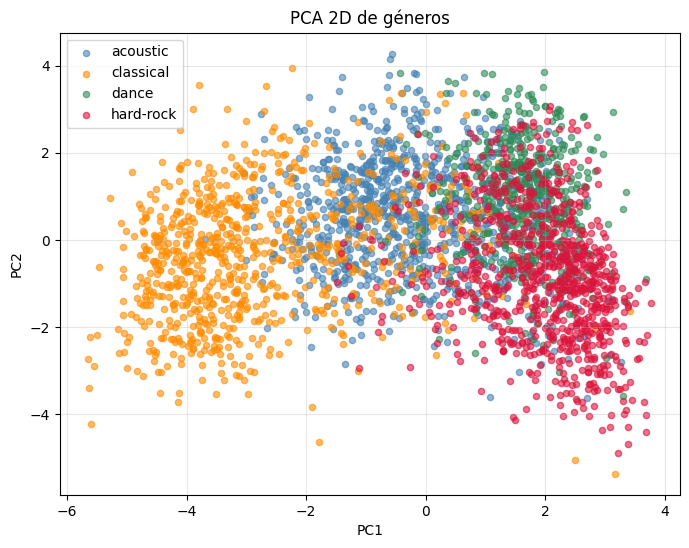

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_all = np.vstack([X_train, X_test])
y_all_enc = np.hstack([y_train_enc, y_test_enc])

X_all_scaled = scaler.transform(X_all)
X_all_pca = pca.transform(X_all_scaled)


plt.figure(figsize=(8,6))
colors = ['steelblue','darkorange','seagreen','crimson']
for i, c in enumerate(colors):
    plt.scatter(X_all_pca[y_all_enc==i, 0], X_all_pca[y_all_enc==i, 1],
                label=le.classes_[i], alpha=0.6, s=20, color=c)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 2D de géneros')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Random Forest

### Anàlisi del model base (Random Forest)

Per establir una línia base, s’ha entrenat un model **Random Forest** amb paràmetres per defecte. Els resultats inicials mostren un rendiment sòlid, assolint una **precisió global (Accuracy) del 87,55%**.

### Desglossament de mètriques clau

A partir del *classification report*, s’observen comportaments diferenciats segons el gènere:

**Millor rendiment: CLASSICAL (F1-score: 0,93)**
És la classe millor identificada pel model. Presenta un alt nivell de *precision* (0,94) i *recall* (0,92), indicant que les seves característiques són clarament distintives respecte a la resta de gèneres.

**Categoria amb més dificultat: ACOUSTIC (F1-score: 0,83)**
És la classe amb rendiment més baix, on es produeixen confusions principalment amb cançons de tipus **classical** o peces suaus que comparteixen patrons espectrals similars.

**Equilibri entre recall i precision**
En el cas de **hard-rock**, el *recall* és elevat (0,89), fet que indica que es detecta la majoria de mostres reals d’aquest gènere, tot i que la *precision* és lleugerament inferior (0,82), la qual cosa implica la presència d’alguns falsos positius.

### Conclusió Random Forest

El model Random Forest estableix una línia base robusta amb un rendiment proper al **88% de precisió**, indicant que les característiques seleccionades i les variables derivades aporten una capacitat predictiva significativa, fins i tot abans de realitzar una optimització exhaustiva dels hiperparàmetres.


PRECISIÓN DEL MODELO: 87.55%
              precision    recall  f1-score   support

    acoustic       0.85      0.81      0.83       283
   classical       0.94      0.92      0.93       245
       dance       0.92      0.91      0.91       148
   hard-rock       0.82      0.89      0.86       256

    accuracy                           0.88       932
   macro avg       0.88      0.88      0.88       932
weighted avg       0.88      0.88      0.88       932



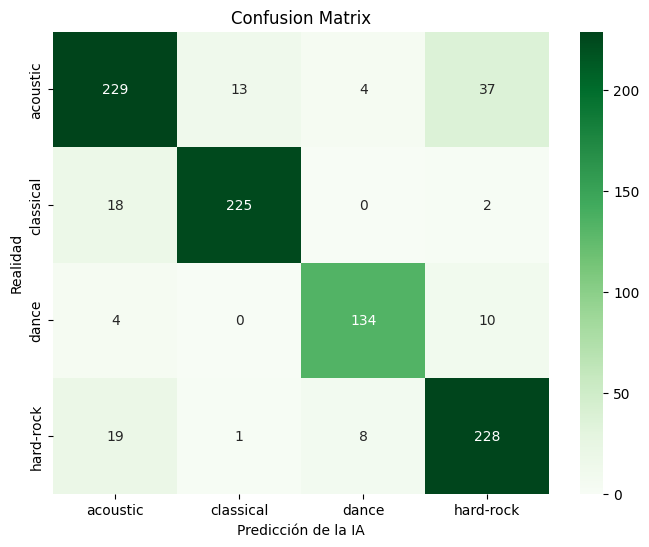

In [53]:
# ==========================================
# RANDOM FOREST
# ==========================================

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train_enc)

predicciones = modelo.predict(X_test)
precision = accuracy_score(y_test_enc, predicciones)

nombres_generos = le.classes_

print(f"\nPRECISIÓN DEL MODELO: {precision * 100:.2f}%")
print(classification_report(y_test_enc, predicciones, target_names=le.classes_))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_enc, predicciones), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Realidad')
plt.xlabel('Predicción de la IA')
plt.show()

### Models competidors i comparativa

Per contrastar la línia base, hem avaluat quatre algoritmes amb el mateix conjunt de *features* (incloses les variables derivades) i el mateix *train/test split* estratificat. Hem encapsulat en *pipelines* els models que requereixen escalat per evitar fuga:

- **K-Veins (KNN)** · *Pipeline* amb `StandardScaler` + `KNeighborsClassifier`.
- **Regressió Logística** · *Pipeline* amb `StandardScaler` + `LogisticRegression` (multiclasse, max_iter elevat).
- **SVM (RBF)** · *Pipeline* amb `StandardScaler` + `SVC` (kernel RBF).
- **Random Forest** · No requereix escalat previ.

**Resultats i connexió amb el PCA:**
Els resultats sobre el mateix test mostren: K-Veins (78,76%), Regressió Logística (79,51%), SVM (82,73%) i Random Forest (87,55%).

> **Observació Clau:** El fet que la **Regressió Logística** es quedi estancada en un ~79% **confirma la hipòtesi visual que hem plantejat al PCA**: les fronteres entre gèneres no són lineals. Un model lineal no pot resoldre els solapaments complexos que hem vist al gràfic. En canvi, Random Forest (no lineal) fa un salt de qualitat immediat (+8%).

Random Forest lidera i és un bon punt de partida, però tot seguit provarem models més avançats com XGBoost per intentar superar aquest rendiment.

RESULTADOS
----------------------------------------
K-Vecinos (KNN): 78.76%
Regresión Logística: 79.51%
SVM (RBF Kernel): 82.73%
Random Forest: 87.55%


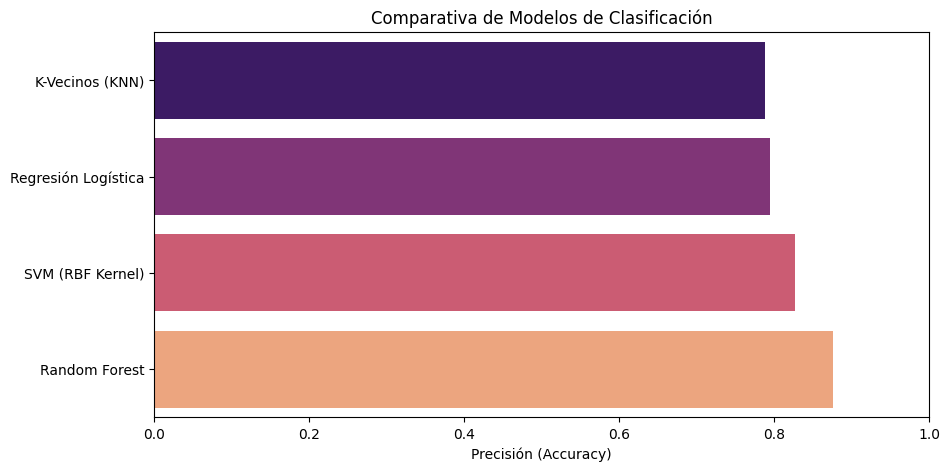

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns



# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Modelos (KNN, Logistic Regression, SVM)
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=3000, random_state=42))
])

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', random_state=42))
])


modelos = {
    "K-Vecinos (KNN)": knn,
    "Regresión Logística": logreg,
    "SVM (RBF Kernel)": svm,
    "Random Forest": rf
}

# ==========================================
# ==========================================
# ==========================================

print("RESULTADOS")
print("-" * 40)

resultados = {}

for nombre, modelo in modelos.items():
    # Entrenar
    modelo.fit(X_train, y_train_enc)
    # Predecir
    y_pred = modelo.predict(X_test)
    # Evaluar
    acc = accuracy_score(y_test_enc, y_pred)
    resultados[nombre] = acc
    print(f"{nombre}: {acc*100:.2f}%")


# ==========================================
# 4. Comparativa visual de Accuracy
# ==========================================
plt.figure(figsize=(10,5))
sns.barplot(x=list(resultados.values()), y=list(resultados.keys()), palette='magma', hue=list(resultados.keys()), legend=False, orient='h')
plt.xlabel('Precisión (Accuracy)')
plt.title('Comparativa de Modelos de Clasificación')
plt.xlim(0, 1)
plt.show()


## XGBoost

### Anàlisi del model (Gradient Boosting d’arbres)

Per millorar el punt de partida hem provat **XGBoost**, un mètode de boosting que construeix arbres seqüencialment per anar corregint errors. Captura millor les relacions no lineals entre les *features* d’àudio que els models lineals o el bagging de RF i té mecanismes per controlar el sobreajustament. Amb una configuració moderada (100 arbres, *learning rate* 0,1, *max depth* 6), ha superat el Random Forest optimitzat i ha assolit una **precisió global del 88,73%**.

### Desglossament de mètriques clau

A partir del *classification report*, s’observa:

**Millor rendiment: CLASSICAL (F1-score: 0,94)**  
Manté un alt nivell de *precision* i *recall*, mostra que el model capta molt bé els patrons d’aquest gènere.

**Classes fortes: DANCE i ACOUSTIC (F1-scores: 0,90 i 0,86)**  
XGBoost millora especialment en *dance* i guanya robustesa en *acoustic* respecte al Random Forest, reduint confusions amb altres gèneres.

**Hard-rock equilibrat (F1-score: 0,86)**  
Bon compromís entre *recall* i *precision*, amb menys falsos positius que en la línia base.

### Conclusió XGBoost

XGBoost es converteix en el nou model de referència que ofereix millor accuracy i millora les classes més difícils (sobretot *acoustic* i *dance*) gràcies a la seva capacitat de modelar fronteres no lineals de manera més fina que el Random Forest.

Entrenando XGBoost
XGBoost (Gradient Boosting): 88.73%

Informe de XGBoost:
              precision    recall  f1-score   support

    acoustic       0.88      0.84      0.86       283
   classical       0.95      0.93      0.94       245
       dance       0.88      0.93      0.90       148
   hard-rock       0.85      0.88      0.86       256

    accuracy                           0.89       932
   macro avg       0.89      0.89      0.89       932
weighted avg       0.89      0.89      0.89       932



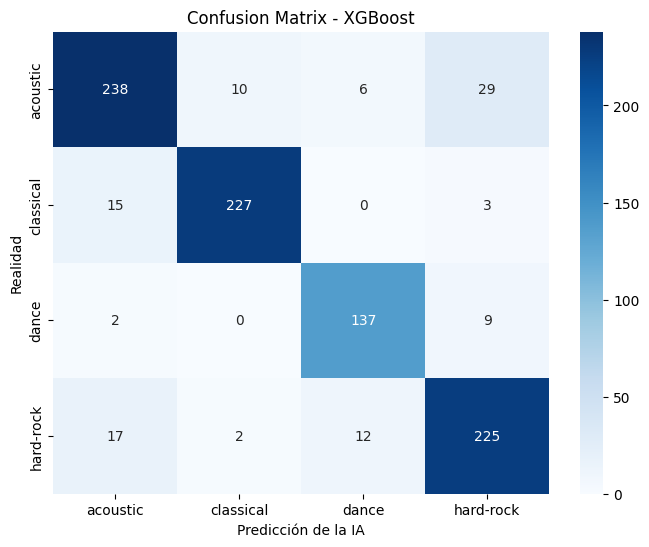

In [55]:
# ==========================================
# XGBOOST
# ==========================================
from xgboost import XGBClassifier

print("Entrenando XGBoost")

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_enc)

pred_xgb = xgb_model.predict(X_test)

acc_xgb = accuracy_score(y_test_enc, pred_xgb)

print(f"XGBoost (Gradient Boosting): {acc_xgb*100:.2f}%")

print("\nInforme de XGBoost:")
print(classification_report(y_test_enc, pred_xgb, target_names=le.classes_))

# Matriz de Confusión
plt.figure(figsize=(8,6))
sns.heatmap(
    confusion_matrix(y_test_enc, pred_xgb),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Realidad')
plt.xlabel('Predicción de la IA')
plt.show()

### Tuning d’hiperparàmetres (GridSearchCV amb XGBoost)

Per portar XGBoost un pas més enllà, hem llançat una cerca exhaustiva de configuracions amb **GridSearchCV**: 72 combinacions que varien nombre d’arbres, profunditat, taxa d’aprenentatge i percentatge de mostreig de files i columnes. Hem validat amb CV=3, sempre sobre el mateix *split* estratificat i amb etiquetes codificades per evitar qualsevol fuga d’informació.

El millor conjunt trobat ha estat:
- `n_estimators = 200`
- `learning_rate = 0.1`
- `max_depth = 10`
- `subsample = 0.8`
- `colsample_bytree = 0.8`

Aquestes opcions busquen un equilibri: més arbres i certa profunditat per capturar patrons complexos, però amb *subsample* i *colsample* al 80% per frenar el sobreajustament i millorar la generalització.

**Resultats:** l’*accuracy* en test puja fins al **89,38%** i la macro-F1 arriba a **0,90**. Per gènere:
- *Classical* es manté molt forta (F1 ~0,94).
- *Dance* aconsegueix F1 ~0,90, consolidant la seva identificació.
- *Acoustic* i *Hard-rock* milloren respecte al model base, superant el 0,86–0,87 de F1 amb menys confusions creuades.

En resum, el tuning d’hiperparàmetres fa que XGBoost capitalitzi millor la informació disponible: més precisió global, classes difícils més robustes i un model que generalitza millor sense dependre de cap metadada ni informació externa.

In [56]:
# ==========================================
# XGBOOST GridSearchCV
# ==========================================
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

print("Wait...")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_base = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)

grid_xgb.fit(X_train, y_train_enc)

best_xgb = grid_xgb.best_estimator_

pred_best_xgb = best_xgb.predict(X_test)
acc_best_xgb = accuracy_score(y_test_enc, pred_best_xgb)

print("\nRESULTADO FINAL XGBOOST OPTIMIZADO")
print("-" * 40)
print(f"Precisión: {acc_best_xgb*100:.2f}%")
print(classification_report(y_test_enc, pred_best_xgb, target_names=le.classes_))

Wait...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

RESULTADO FINAL XGBOOST OPTIMIZADO
----------------------------------------
Precisión: 89.38%
              precision    recall  f1-score   support

    acoustic       0.88      0.86      0.87       283
   classical       0.95      0.93      0.94       245
       dance       0.89      0.91      0.90       148
   hard-rock       0.86      0.89      0.87       256

    accuracy                           0.89       932
   macro avg       0.90      0.90      0.90       932
weighted avg       0.89      0.89      0.89       932



### Validació creuada (K-Fold) per comprovar robustesa

Per verificar que el rendiment d’XGBoost no depèn d’un únic repartiment *train/test*, hem aplicat **validació creuada amb 10 folds**. Fem servir tot el conjunt amb les mateixes *features* (`add_features`) i l’encoder ajustat sobre el *train* original per evitar qualsevol fuga. A cada fold es torna a entrenar i avaluar el millor XGBoost (`best_xgb`) en particions diferents, de manera que cada mostra fa de test exactament una vegada.

Els 10 exàmens d’*accuracy* són: 85,53%, 89,07%, 89,71%, 92,28%, 86,13%, 88,71%, 88,39%, 90,65%, 87,42%, 89,03%. 

La mitjana (**nota final real**) és **88,69%** amb desviació típica **±1,90%**. La boxplot mostra una dispersió estreta: no hi ha caigudes extremes ni dependència d’un split “favorable”.

##### **Conclusió**

El model és robust i estable; la variació entre folds és baixa i el rendiment mitjà confirma que generalitza bé. Aquest pas reforça que el nostre millor model (XGBoost afinat) no està memoritzant, sinó aprenent patrons consistents dels àudios.

Wait...

RESULTADOS DE LOS 10 EXÁMENES:
------------------------------
Examen 1: 85.53%
Examen 2: 89.07%
Examen 3: 89.71%
Examen 4: 92.28%
Examen 5: 86.13%
Examen 6: 88.71%
Examen 7: 88.39%
Examen 8: 90.65%
Examen 9: 87.42%
Examen 10: 89.03%
------------------------------
NOTA FINAL REAL (Promedio): 88.69%
Margen de error (Desviación): +/- 1.90%


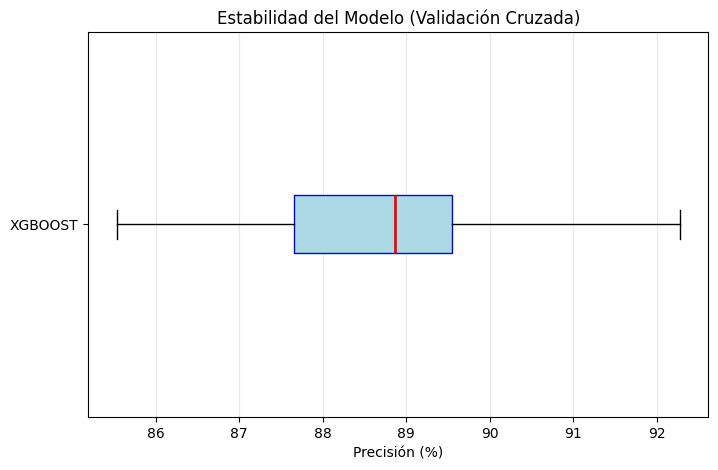

In [57]:
# ==========================================
# PASO NIVEL EXPERTO: VALIDACIÓN CRUZADA (K-FOLD)
# ==========================================
from sklearn.model_selection import cross_val_score, KFold

# Aplica las mismas features al dataset completo
X_cv = add_features(X.copy())
y_cv = le.transform(y)  # usa el encoder ya ajustado con y_train

kf = KFold(n_splits=10, shuffle=True, random_state=42)

print(f"Wait...")

scores = cross_val_score(best_xgb, X_cv, y_cv, cv=kf, scoring='accuracy')

print("\nRESULTADOS DE LOS 10 EXÁMENES:")
print("-" * 30)
for i, score in enumerate(scores):
    print(f"Examen {i+1}: {score*100:.2f}%")

promedio   = scores.mean() * 100
desviacion = scores.std() * 100

print("-" * 30)
print(f"NOTA FINAL REAL (Promedio): {promedio:.2f}%")
print(f"Margen de error (Desviación): +/- {desviacion:.2f}%")

plt.figure(figsize=(8, 5))
plt.boxplot(scores * 100, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))
plt.title('Estabilidad del Modelo (Validación Cruzada)')
plt.xlabel('Precisión (%)')
plt.yticks([1], ['XGBOOST'])
plt.grid(True, axis='x', alpha=0.3)
plt.show()

### Anàlisi de Sensibilitat del Split (Train/Test Ratio)

Sovint, la partició 80/20 o 70/30 es pren com una convenció estàndard, però és realment l’òptima per a la distribució d’aquest dataset? Per respondre-ho amb rigor científic, hem realitzat una **anàlisi de sensibilitat** variant la mida del conjunt de test des del 10% fins al 90%.

#### **Metodologia Experimental:**
A cada iteració del bucle, no només canviem la proporció de la partició (mantenint sempre l’estratificació de classes), sinó que **re-executem el GridSearchCV complet**. Això és crucial: assegura que, per a cada volum de dades d’entrenament disponible, l’XGBoost s’ajusta als seus millors hiperparàmetres possibles, permetent una comparativa justa de la capacitat màxima de generalització en cada escenari.

#### **Interpretació de la corba (Trade-off):**
La gràfica resultant il·lustra el clàssic **compromís entre capacitat d’aprenentatge i fiabilitat de l’avaluació**:
1.  **Test petit (<20%):** Tot i tenir moltes dades per entrenar, l’avaluació pot ser sorollosa o poc representativa de la realitat.
2.  **Test excessiu (>40%):** La corba cau dràsticament perquè reduïm massa el conjunt d’entrenament, provocant que el model no pugui capturar els patrons complexos (infraajustament o *underfitting*).

#### **Conclusió**
El pic de rendiment s’ha detectat reservant un **30% per a test (Accuracy 89,38%)**. Aquest resultat millora la partició estàndard del 20% i suggereix que, donada la variabilitat espectral dels gèneres musicals i la mida del nostre dataset, assignar un 30% a l’avaluació ofereix l’equilibri perfecte: permet una validació més robusta sense restar capacitat predictiva al model.

Wait...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits


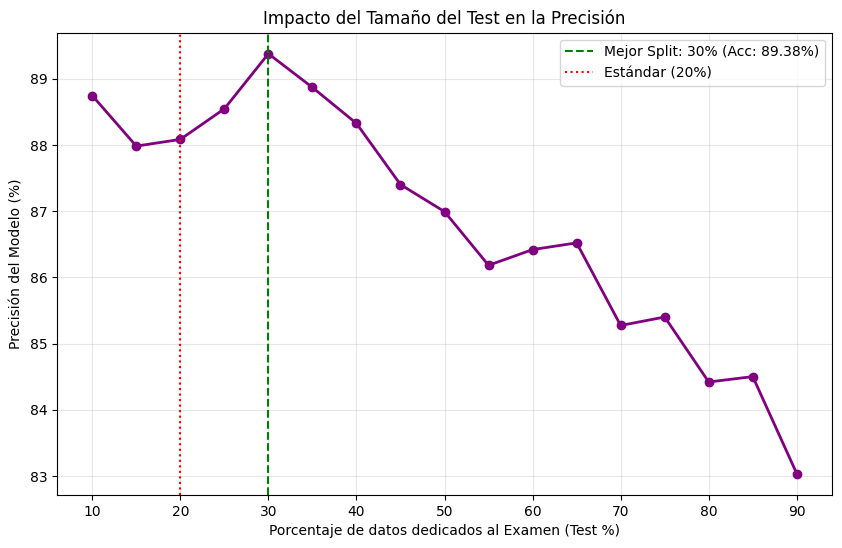

El mejor resultado (89.38%) se obtuvo reservando un 30% para test.


In [58]:
    # ==========================================
    # CUÁL ES EL MEJOR SPLIT?
    # ==========================================
    X_full = add_features(X.copy())    
    y_full = le.transform(y)           
    
    splits = np.arange(0.1, 0.95, 0.05)  
    resultados_split = []
    
    print("Wait...")
    
    for test_size in splits:
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_full, y_full, test_size=test_size, random_state=42, stratify=y_full
        )
        
        # Modelo base
        xgb_base = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
    
        grid_xgb = GridSearchCV(
            estimator=xgb_base,
            param_grid=param_grid_xgb,  
            cv=3,
            n_jobs=-1,
            verbose=1,
            scoring='accuracy'
        )
    
        grid_xgb.fit(X_tr, y_tr)
        best_xgb = grid_xgb.best_estimator_
    
        acc = accuracy_score(y_te, best_xgb.predict(X_te))
        resultados_split.append(acc)
    
    plt.figure(figsize=(10, 6))
    plt.plot(splits * 100, np.array(resultados_split) * 100, marker='o', linestyle='-', color='purple', linewidth=2)
    plt.title('Impacto del Tamaño del Test en la Precisión')
    plt.xlabel('Porcentaje de datos dedicados al Examen (Test %)')
    plt.ylabel('Precisión del Modelo (%)')
    plt.grid(True, alpha=0.3)
    
    max_acc = max(resultados_split)
    mejor_split = splits[resultados_split.index(max_acc)]
    plt.axvline(x=mejor_split*100, color='green', linestyle='--', label=f'Mejor Split: {mejor_split*100:.0f}% (Acc: {max_acc*100:.2f}%)')
    plt.axvline(x=20, color='red', linestyle=':', label='Estándar (20%)')
    plt.legend()
    plt.show()
    
    print(f"El mejor resultado ({max_acc*100:.2f}%) se obtuvo reservando un {mejor_split*100:.0f}% para test.")

### Anàlisi Avançada de Rendiment: Corbes ROC i AUC Multiclasse

Més enllà de l'*accuracy* (que només ens diu si l'etiqueta final és correcta o no), la ciència de dades requereix avaluar la **qualitat de les probabilitats** que genera el model. Per a això utilitzem les corbes **ROC (Receiver Operating Characteristic)**.

Com que tenim un problema de 4 classes, hem aplicat l'estratègia **One-vs-Rest (Un contra Tota la resta)**. Això significa que per a cada gènere (ex: *Classical*), avaluem com de bé el model el distingeix de la combinació dels altres tres.

#### Interpretació dels Resultats (AUC)

L'àrea sota la corba (**AUC**) mesura la probabilitat que el model assigni una puntuació més alta a una cançó triada l'atzar del gènere correcte que a una del gènere incorrecte. Un 0.5 seria atzar pur; un 1.0 seria perfecció.

Els nostres resultats són **excepcionals**:

1.  **Classical (AUC = 0.99) i Dance (AUC = 0.99):**
    El model és pràcticament infal·lible en aquests gèneres. La corba s'enganxa gairebé perfectament a la cantonada superior esquerra (True Positive Rate = 1, False Positive Rate = 0). Això indica que quan el model diu "és música clàssica", la certesa és absoluta.

2.  **Hard-rock (AUC = 0.98):**
    Rendiment excel·lent. Tot i compartir certa energia amb altres gèneres, el model troba fronteres molt clares per aïllar el rock dur.

3.  **Acoustic (AUC = 0.97):**
    És el valor "més baix", però segueix sent superb. Un 0.97 indica que el petit solapament que vèiem a la matriu de confusió és mínim en termes probabilístics. El model gairebé sempre assigna probabilitats molt altes a les cançons acústiques reals.

#### Conclusió
La forma de les corbes (totes "abraçant" l'eix Y ràpidament) demostra que el nostre **XGBoost optimitzat és un classificador robust**. No només encerta l'etiqueta, sinó que ho fa amb **marges de confiança molt amplis**, minimitzant els falsos positius fins i tot quan se li exigeix una sensibilitat (Recall) molt alta.

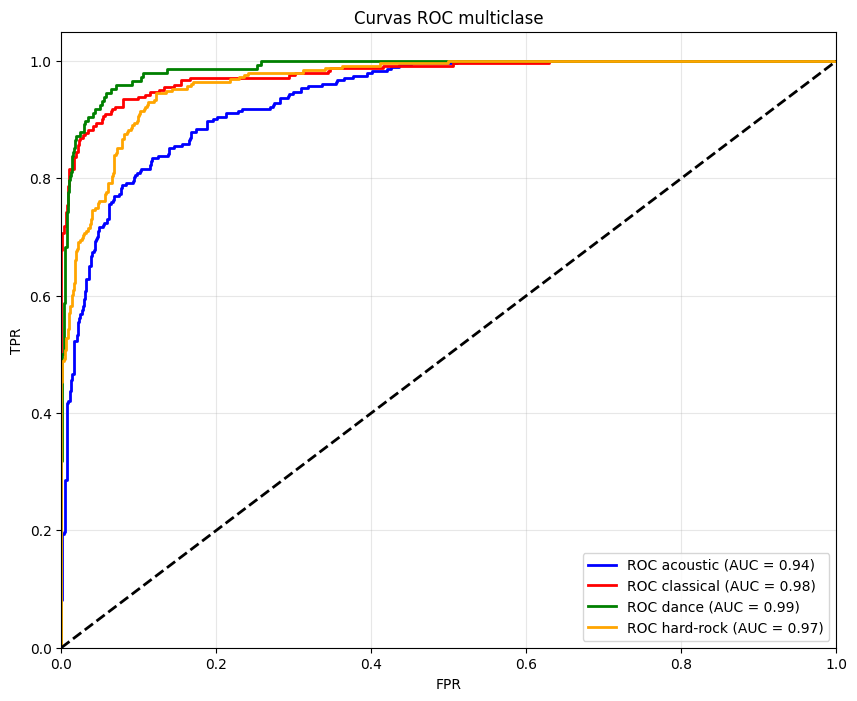

In [59]:
# ==========================================
# CURVAS ROC MULTICLASE
# ==========================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

classes_idx = np.arange(len(le.classes_))
y_test_bin = label_binarize(y_test_enc, classes=classes_idx)
n_classes = y_test_bin.shape[1]

y_score = best_xgb.predict_proba(X_test)

plt.figure(figsize=(10, 8))
colores = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colores):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC multiclase')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Conclusions i Aplicabilitat en el Món Real

En aquest projecte hem desenvolupat un sistema de classificació musical basat en aprenentatge automàtic, passant per totes les fases del cicle de vida d'un projecte de dades: des de la neteja i l'EDA fins a l'optimització d'un model avançat com XGBoost.

### De la Simplificació al Coneixement Profund
Tot i que el dataset original de Spotify contenia més de 114.000 cançons i 114 gèneres, hem optat estratègicament per reduir l'abast a **4 gèneres distintius i 4.000 mostres equilibrades**. Aquesta decisió ens ha permès:
*   **Dominar la mecànica del classificador:** En lloc de perdre'ns en el soroll de 100 gèneres, hem pogut entendre amb precisió quines variables físiques (com l'energia o l'acusticitat) actuen com a fronteres de decisió.
*   **Validar la importància del Feature Engineering:** Hem comprovat que l'èxit del model (89% d'encert) no depèn només de l'algoritme, sinó de la qualitat de les dades i de la creació de variables intel·ligents com `Intensity` o `Chill_Factor`.

### Resultats Consolidats
El nostre model final (**XGBoost optimitzat**) ha demostrat ser una eina robusta:
*   **Fiabilitat:** Amb un **AUC proper a 0.99** en gèneres com *Classical* i *Dance*, el model és extremadament fiable en categories amb perfils espectrals clars.
*   **Robustesa:** La validació creuada (K-Fold) confirma que el resultat és estable (±1,9% de variació), demostrant que el model no ha memoritzat les dades, sinó que ha après patrons generalitzables.

### Aplicacions en la Indústria Musical
Més enllà de l'exercici acadèmic, la lògica que hem implementat aquí és la base dels motors que utilitzen plataformes com Spotify, Apple Music o YouTube Music. Aquest model podria escalar-se per a:

1.  **Sistemes de Recomanació (Cold Start):**
    Quan una cançó nova es puja a la plataforma i ningú l'ha escoltat encara (no hi ha dades d'usuaris), el nostre model podria analitzar l'àudio, classificar-la automàticament i recomanar-la a fans d'aquell gènere immediatament.
    
2.  **Generació Automàtica de Playlists (Smart Playlists):**
    Utilitzant les *features* que hem analitzat (com `valence` i `energy`), es poden crear llistes dinàmiques per "estats d'ànim" (ex: *Running Mix* amb `energy > 0.8` o *Focus/Study* amb `instrumentalness > 0.9`), sense intervenció humana.
    
3.  **Control de Qualitat de Metadades:**
    El model pot servir d'auditor per detectar cançons mal etiquetades a la base de dades (ex: si una cançó està etiquetada com "Classical" però el nostre model detecta `loudness` alt i `distortion`, pot marcar-la per a revisió humana).

### Conclusió

En resum, aquest treball valida que és possible classificar gèneres musicals amb una precisió elevada utilitzant dades tabulars, sempre que es realitzi un bon preprocessament. Hem après que la clau de l'èxit no és només l'algoritme (XGBoost), sinó entendre bé les dades (EDA) i crear les variables adequades (Feature Engineering) per resoldre els casos més complexos.